In [28]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from plotting_functions import *

# Set seed
torch.manual_seed(0)

In [29]:
# Features that require StandardScaler (price-dependent and volume-based)
standard_features = ['EMA_5', 'MA_5', 'Returns', 'net_ask_size',
       'net_bid_size', 'trade_ask_size', 'trade_bid_size', 'Bollinger_Upper', 'Bollinger_Lower']

# Features that require MinMaxScaler (bounded indicators)
minmax_features = ['DMP_3', 'DMN_3', 'OLL3', 'OLL5', 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'time_since_open']

unscaled_features = ["market_session"]

features = standard_features + minmax_features + unscaled_features

sampling_rate = "2s"
prediction_column = "Target"
batch_size = 10
epochs = 8
look_back = 32

In [30]:
from preprocessing import combine_data, add_time_features

# Generate file paths dynamically
start_date = pd.to_datetime("2024-10-02")
end_date = pd.to_datetime("2024-10-02")
date_range = pd.bdate_range(start=start_date, end=end_date)

data_paths = [f"AAPL_data/AAPL_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet" for date in date_range]

data_hft = combine_data(data_paths, sampling_rate)
data_hft = add_time_features(data_hft)

print(data_hft.columns)

data_hft.head()

Index(['mid_price_high', 'mid_price_low', 'mid_price_close', 'mid_price_open',
       'Returns', 'Target', 'add_ask_size', 'add_bid_size', 'cancel_ask_size',
       'cancel_bid_size', 'trade_ask_size', 'trade_bid_size', 'net_ask_size',
       'net_bid_size', 'EMA_5', 'MA_5', 'Bollinger_Upper', 'Bollinger_Lower',
       'DMP_3', 'DMN_3', 'OLL3', 'OLL5', 'STOCHk_7_3_3', 'STOCHd_7_3_3',
       'time_since_open', 'dow_2', 'market_session'],
      dtype='object')


,mid_price_high,mid_price_low,mid_price_close,mid_price_open,Returns,Target,add_ask_size,add_bid_size,cancel_ask_size,cancel_bid_size,...,Bollinger_Lower,DMP_3,DMN_3,OLL3,OLL5,STOCHk_7_3_3,STOCHd_7_3_3,time_since_open,dow_2,market_session
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-02 09:30:00-04:00,226.135,225.730,225.780,225.880,-0.000421,-1.0,14663.0,24348.0,12975.0,19822.0,...,225.771029,0.255,0.00,0.150,0.150,12.345679,31.172840,0.0,1,0
2024-10-02 09:30:02-04:00,225.810,225.550,225.555,225.775,-0.000997,-1.0,34124.0,15591.0,30264.0,9505.0,...,225.514547,0.255,0.18,0.225,0.225,0.854701,21.066793,2.0,1,0
2024-10-02 09:30:04-04:00,225.720,225.420,225.610,225.555,0.000244,1.0,7484.0,12515.0,6421.0,21307.0,...,225.440387,0.255,0.31,0.135,0.135,26.573427,13.257935,4.0,1,0
2024-10-02 09:30:06-04:00,225.835,225.590,225.675,225.610,0.000288,1.0,14718.0,18048.0,13861.0,14719.0,...,225.440601,0.115,0.31,0.190,0.190,35.664336,21.030821,6.0,1,0
2024-10-02 09:30:08-04:00,225.700,225.675,225.695,225.675,0.000089,1.0,2300.0,600.0,2535.0,525.0,...,225.491740,0.115,0.13,0.255,0.255,38.461538,33.566434,8.0,1,0


In [31]:
# Data splitting

train_size = int(len(data_hft) * 0.7)
val_size = int(len(data_hft) * 0.1)
test_size = len(data_hft) - train_size - val_size

train_df = data_hft.iloc[:train_size, :]
val_df = data_hft.iloc[train_size : train_size + val_size, :]
test_df = data_hft.iloc[train_size + val_size :, :]

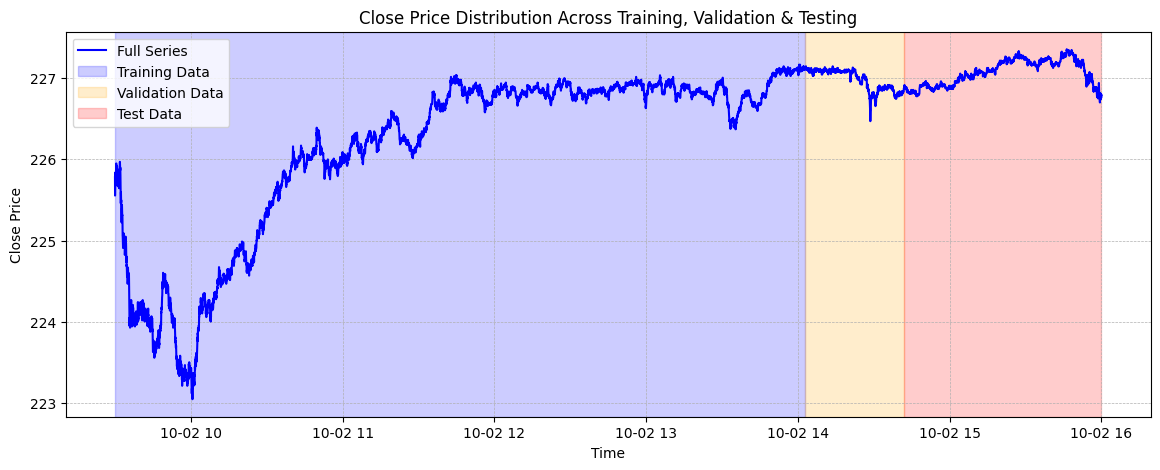

In [32]:
plot_close_price_split(data_hft, train_size, val_size)

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_indices = [train_df.columns.get_loc(col) for col in standard_features]
minmax_indices = [train_df.columns.get_loc(col) for col in minmax_features]
unscaled_indices = [train_df.columns.get_loc(col) for col in unscaled_features]

class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, look_back):
        self.data = data
        self.targets = targets
        self.look_back = look_back

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, index):
        x = self.data[index : index + self.look_back]
        y = self.targets[index + self.look_back]

        # Extract features using global variables
        x_standard = x[:, standard_indices]
        x_minmax = x[:, minmax_indices]
        x_unscaled = x[:, unscaled_indices]

        # Scale per-sequence (each time window separately)
        standard_scaler = StandardScaler().fit(x_standard)  
        minmax_scaler = MinMaxScaler(feature_range=(0, 1)).fit(x_minmax)

        x_standard_scaled = standard_scaler.transform(x_standard)
        x_minmax_scaled = minmax_scaler.transform(x_minmax)

        x_scaled = np.hstack((x_standard_scaled, x_minmax_scaled, x_unscaled))

        return torch.tensor(x_scaled, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [34]:
# Create dataset and dataloaders
train_dataset = TimeSeriesDataset(train_df.values, train_df[prediction_column].values, look_back)
val_dataset = TimeSeriesDataset(val_df.values, val_df[prediction_column].values, look_back)
test_dataset = TimeSeriesDataset(test_df.values, test_df[prediction_column].values, look_back)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

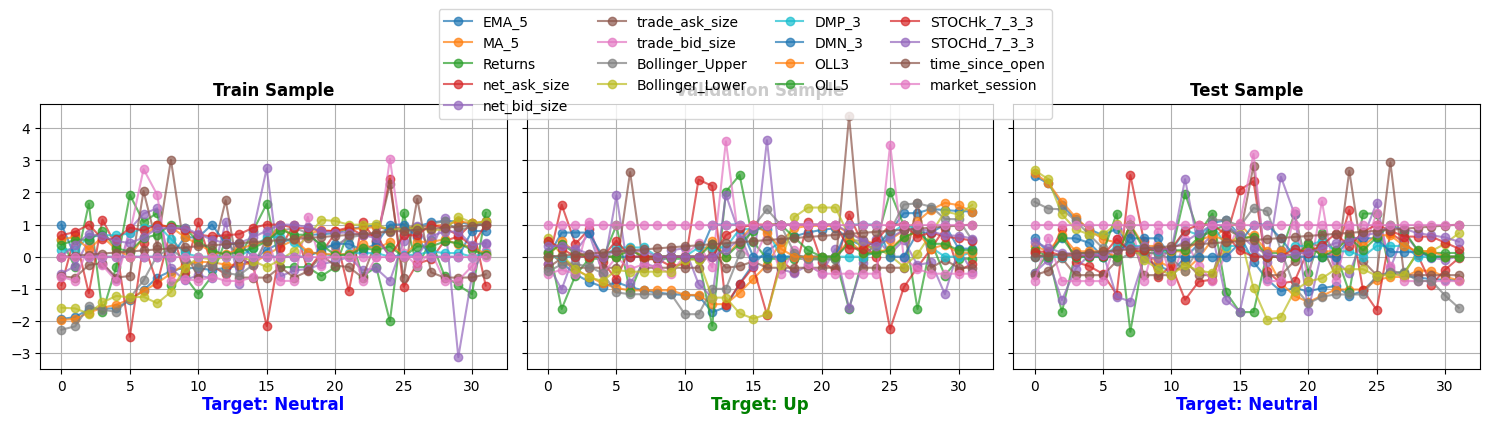

In [35]:
plot_samples([train_dataset, val_dataset, test_dataset], 
             ["Train Sample", "Validation Sample", "Test Sample"], features)


In [36]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 3)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :] 
        lstm_out = self.batch_norm(lstm_out)
        x = self.fc(lstm_out)
        return self.softmax(x)

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size=len(features))
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training started...
Epoch 1/8 - Start time: 12:23:31
  Batch 1/816 (Total: 1/6528) | Time elapsed: 0.03s
  Batch 501/816 (Total: 501/6528) | Time elapsed: 13.51s
  Batch 816/816 (Total: 816/6528) | Time elapsed: 22.63s
Epoch 1 completed in 24.09s
Train Loss: 1.0979, Train Acc: 0.3810
Val Loss: 1.1229, Val Acc: 0.3541

Epoch 2/8 - Start time: 12:23:55
  Batch 1/816 (Total: 817/6528) | Time elapsed: 0.05s
  Batch 501/816 (Total: 1317/6528) | Time elapsed: 15.32s
  Batch 816/816 (Total: 1632/6528) | Time elapsed: 24.77s
Epoch 2 completed in 26.22s
Train Loss: 1.0856, Train Acc: 0.3885
Val Loss: 1.1265, Val Acc: 0.3190

Epoch 3/8 - Start time: 12:24:21
  Batch 1/816 (Total: 1633/6528) | Time elapsed: 0.03s
  Batch 501/816 (Total: 2133/6528) | Time elapsed: 15.71s
  Batch 816/816 (Total: 2448/6528) | Time elapsed: 25.44s
Epoch 3 completed in 26.98s
Train Loss: 1.0838, Train Acc: 0.3999
Val Loss: 1.1195, Val Acc: 0.3436

Epoch 4/8 - Start time: 12:24:48
  Batch 1/816 (Total: 2449/6528) | Tim

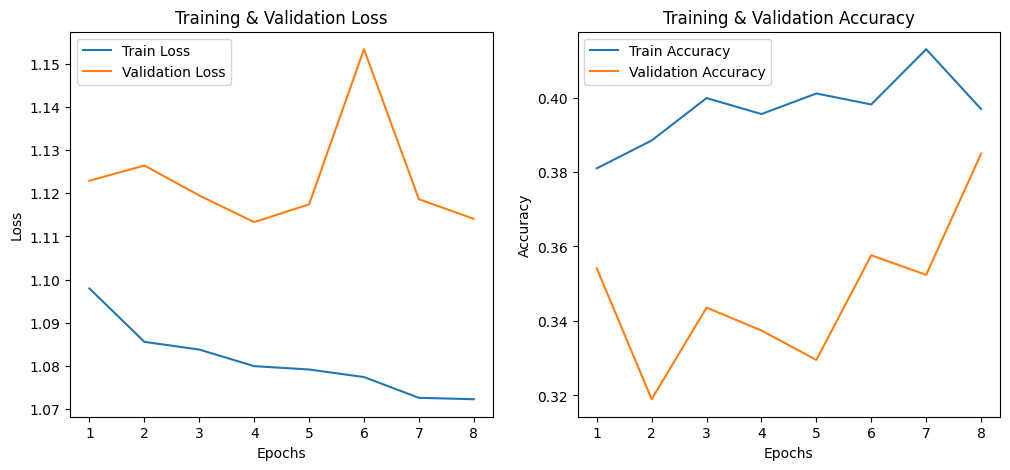

In [37]:
def train_model(model, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    total_batches = len(train_loader) * epochs
    batch_count = 0

    print("Training started...")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch + 1}/{epochs} - Start time: {time.strftime('%H:%M:%S')}")
        
        model.train()
        train_loss = 0.0
        correct_train, total_train = 0, 0


        for batch_idx, (inputs, targets) in enumerate(train_loader):
            batch_count += 1

            optimizer.zero_grad()
            outputs = model(inputs)

            targets_shifted = targets + 1

            loss = criterion(outputs, targets_shifted)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            
            correct_train += (predicted == targets_shifted).sum().item()
            total_train += targets.size(0)

            if batch_idx % 500 == 0 or batch_idx == len(train_loader) - 1:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)} (Total: {batch_count}/{total_batches}) | Time elapsed: {time.time() - epoch_start:.2f}s")

        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)

                targets_shifted = targets + 1

                loss = criterion(outputs, targets_shifted)

                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)

                correct_val += (predicted == targets_shifted).sum().item()
                total_val += targets.size(0)

        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1} completed in {time.time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}\n")
    
    print(f"Training completed in {time.time() - start_time:.2f}s\n")

    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return model

# Train model
model = train_model(model, train_loader, val_loader, epochs=epochs)

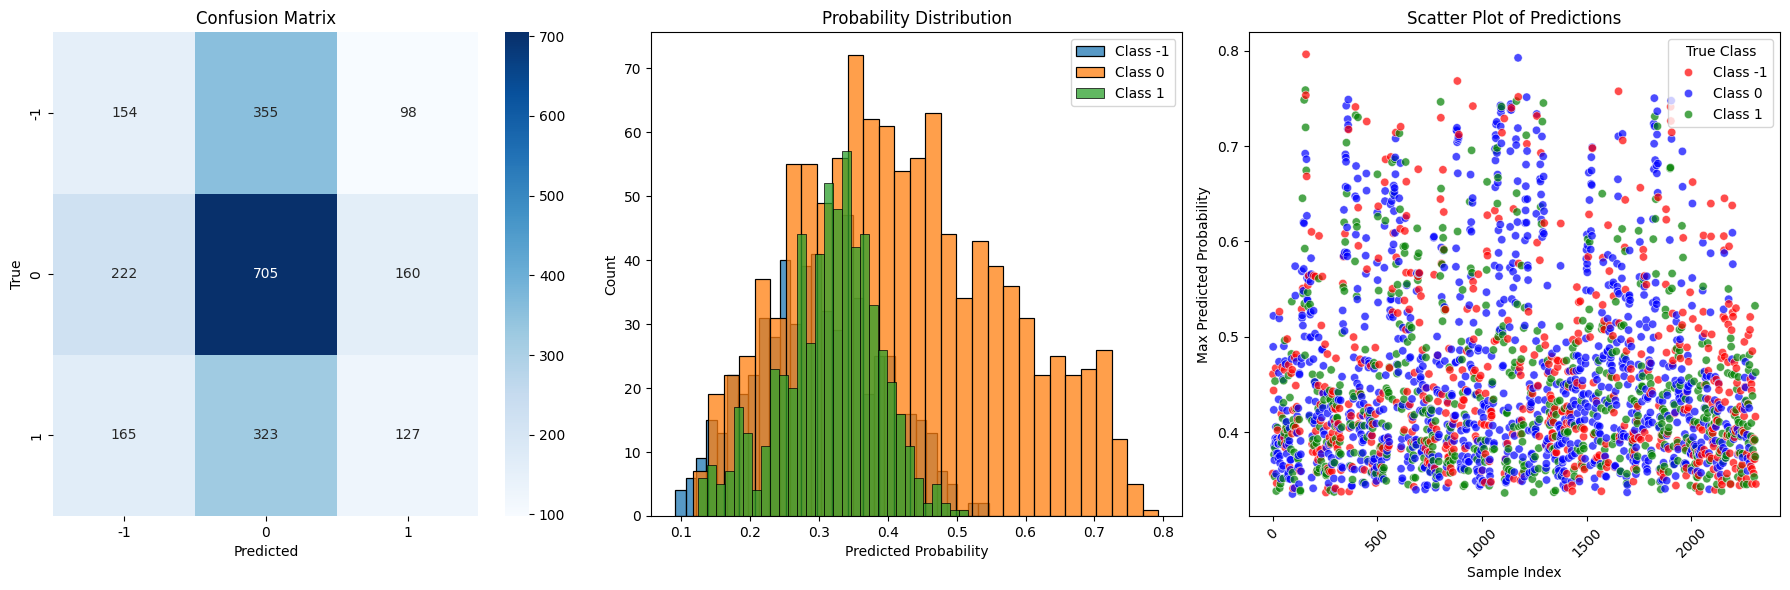

Accuracy: 0.4270
              precision    recall  f1-score   support

          -1       0.28      0.25      0.27       607
           0       0.51      0.65      0.57      1087
           1       0.33      0.21      0.25       615

    accuracy                           0.43      2309
   macro avg       0.37      0.37      0.36      2309
weighted avg       0.40      0.43      0.41      2309



In [38]:
def evaluate_model(model, test_loader):
    """Evaluates the model on a test set and plots relevant metrics."""
    model.eval()
    y_true, y_pred, log_probabilities = [], [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            log_probabilities.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred) - 1
    log_probabilities = np.array(log_probabilities)

    plot_evaluation_metrics(y_true, y_pred, log_probabilities)

    return y_true, y_pred, log_probabilities

y_true, y_pred, log_probabilities = evaluate_model(model, test_loader)

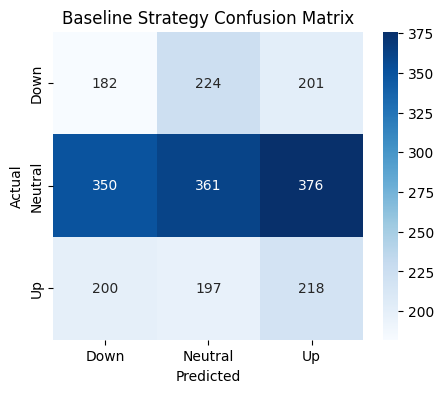

Accuracy: 0.3296
              precision    recall  f1-score   support

        -1.0       0.25      0.30      0.27       607
         0.0       0.46      0.33      0.39      1087
         1.0       0.27      0.35      0.31       615

    accuracy                           0.33      2309
   macro avg       0.33      0.33      0.32      2309
weighted avg       0.36      0.33      0.34      2309



In [39]:
def baseline_strategy(df):
    """Predicts tomorrow's target as a random guess over -1, 0, 1."""
    num_samples = len(df)
    baseline_preds = np.random.choice([-1, 0, 1], size=num_samples)
    
    return baseline_preds, df["Target"]

baseline_preds, baseline_targets = baseline_strategy(test_df.iloc[look_back:, :])

# Plot baseline evaluation metrics
plot_baseline_evaluation_metrics(baseline_targets, baseline_preds)